# 5. Regularization vs Overfitting, Ridge Regression

### About this notebook

This notebook was used in the 50.039 Deep Learning course at the Singapore University of Technology and Design.

**Author:** Matthieu DE MARI (matthieu_demari@sutd.edu.sg)

**Version:** 1.3 (26/01/2025)

**Requirements:**
- Python 3 (tested on v3.13.1)
- Matplotlib (tested on v3.10.0)
- Numpy (tested on v2.2.1)
- Sklearn (tested on v1.6.1)

### Imports

In [1]:
# Matplotlib
import matplotlib.pyplot as plt
# Numpy
import numpy as np
# Sklearn
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.kernel_ridge import KernelRidge
# Removing unecessary warnings (optional, just makes notebook outputs more readable)
import warnings
warnings.filterwarnings("ignore")

### Mock Dataset Generation

As in Notebook 3.

In [2]:
# All helper functions
def surface(min_surf, max_surf):
    return round(np.random.uniform(min_surf, max_surf), 2)
def price(surface):
    # Note: this has changed and is now a polynomial function.
    return round((100000 + 14373*surface + 3*surface**3)*(1 + np.random.uniform(-0.1, 0.1)))/1000000
def generate_datasets(n_points, min_surf, max_surf):
    x = np.array([surface(min_surf, max_surf) for _ in range(n_points)])
    y = np.array([price(i) for i in x])
    return x, y
def linreg_matplotlib(a, b, min_surf, max_surf, n_points = 50):
    x = np.linspace(min_surf, max_surf, n_points)
    y = a*x + b
    return x, y
def loss_mse(a, b, x, y):
    val =  np.sum((y - (a*x + b))**2)/x.shape[0]
    return '{:.2e}'.format(val)

In [3]:
# Dataset generation (n_points points will be generated).
# We will use a seed for reproducibility.
min_surf = 40
max_surf = 150
np.random.seed(77)
n_points = 50
inputs, outputs = generate_datasets(n_points, min_surf, max_surf)
print(inputs)
print(outputs)

[141.1  110.64 122.91  55.32  49.61 126.68  75.88  99.52  66.43 100.
  84.06 118.67 132.03 104.73  72.58  70.91 117.62  86.49  46.3  122.17
  89.75  59.34  45.43  72.17  47.35 122.63  47.01  87.51  80.06  56.72
 100.14  88.76  43.97 130.52  70.06  58.59 110.88  51.83  78.86  82.43
  89.01 147.48 120.23  74.35 138.42 126.16  68.82  74.04  54.24  86.44]
[11.483996  5.600342  7.339926  1.520039  1.28484   7.626262  2.60623
  4.08352   1.792955  4.543204  3.145168  6.583097  8.269885  4.806583
  2.453941  2.269382  7.337575  3.165507  1.053321  7.86496   3.657397
  1.526631  1.042935  2.089377  1.168615  6.982195  1.090599  3.38581
  2.665769  1.580975  4.479488  3.78553   1.04356   8.614462  1.929858
  1.409405  6.160022  1.238571  2.463003  2.822494  3.341987 12.892959
  7.596313  2.258637  9.242983  8.053269  2.168422  2.42982   1.469485
  3.567716]


### Train-Test Splitting

As in Notebook 4, we will use a basic train-test split, with a ratio of 80-20%.

In [4]:
# 80% of the samples will be used for training,
# and the remaining 20% will be used to evaluate generalization/overfitting.
ratio_train = 0.8
split_index = int(n_points*ratio_train)
# Training inputs and outputs
train_inputs = inputs[:split_index]
train_outputs = outputs[:split_index]
# Testing inputs and outputs
test_inputs = inputs[split_index:]
test_outputs = outputs[split_index:]

### Training an overfitting polynomial regressor.

As in Notebook 4, we will use a polynomial regressor with a degree higher than needed (6, instead of 3) and will reuse the helper functions we have introduced earlier.

In [5]:
# Training a Polynomial Regressor
n_degree = 6
sk_inputs = np.array(train_inputs).reshape(-1, 1)
sk_outputs = np.array(train_outputs)
sk_poly = PolynomialFeatures(degree = n_degree, include_bias = False)
sk_poly_inputs = sk_poly.fit_transform(sk_inputs.reshape(-1, 1))
poly_reg_model = LinearRegression()
poly_reg_model.fit(sk_poly_inputs, sk_outputs)
a_sk = poly_reg_model.coef_
b_sk = poly_reg_model.intercept_
print(a_sk, b_sk)

[ 3.82232902e-04  1.26090477e-02 -4.05438476e-04  5.42336678e-06
 -3.30028769e-08  7.59906676e-11] -4.371848484421854


In [6]:
# Polynomial regression of the helper function that will
# help get points for the upcoming matplotlib displays.
def polyreg_matplotlib(poly_reg_model, n_degree, min_surf, max_surf, n_points = 50):
    x = np.linspace(min_surf, max_surf, n_points)
    y = np.array([poly_reg_model.predict(np.array([[i**(j+1) for j in range(n_degree)]]))[0] for i in x])
    return x, y

In [7]:
# Mean square error as a loss function for polynomial regression
# Displaying loss using exponential notation (XXXe-YYY)
def loss_mse_poly(poly_reg_model, n_degree, inputs, outputs):
    pred = np.array([poly_reg_model.predict(np.array([[i**(j+1) for j in range(n_degree)]]))[0] for i in inputs])
    losses = (pred - outputs)**2
    val = sum(losses)/inputs.shape[0]
    return '{:.2e}'.format(val)

In [8]:
# Showing the training and test loss to identify overfitting
loss_train = loss_mse_poly(poly_reg_model, n_degree, train_inputs, train_outputs)
print(loss_train)
loss_test = loss_mse_poly(poly_reg_model, n_degree, test_inputs, test_outputs)
print(loss_test)

5.87e-02
4.29e-01


### Training a Ridge Regressor

The ridge regression is a variant of the polynomial regression model with degree $ M $.

It works more or less the same way, in the sense we have to find some parameters $ a = (a_1, a_2, ..., a_M) $ and $ b $ to fit the data. As before, the assumption made by the ridge regression model is that the outputs $ y $ can be approximated using a polynomial function of the inputs $ x $, with parameters $ a $ and $ b $ to be deciced. More specifically, the outputs and inputs are connected by:

$$ y = f(x) = \sum_{k = 1}^N a_k x^k + b .$$

The difference between the polynomial regression and the ridge regression lies in the loss function being minimized to train both models. In the case of the polynomial regression, we are minimizing the Mean Square Error:

### Loss function

In order to measure the quality of the fit for each model, and evaluate whether the parameters $ (a, b) $ used for the linear regression are good choices or not, we will use a loss function, namely the mean square error  $ L(a, b, x, y) $:

$$ L(a, b, x, y) = \frac{1}{N} \sum_{i=1}^N \left(\left(\sum_{k = 1}^M a_k x_i^k + b \right) - y_i\right)^2 $$

With $ N $ being the number of points in the dataset (i.e. the value in the variable **n_points**) and $ M $ being the degree of the polynomial.

In the case of the Ridge Polynomial Regressor, the loss function is the same, but an additional **regularization term** $ \lambda R(a, b) $ is added to the loss function

$$ L(a, b, x, y) = \frac{1}{N} \sum_{i=1}^N \left(\left(\sum_{k = 1}^M a_k x_i^k + b \right) - y_i\right)^2 + \lambda R(a, b) $$

This regularization term simply consists of the sum of the squared values for the parameters in $ a $ and $ b $, i.e.:

$$ \lambda R(a, b) = \frac{\lambda}{2N} \left( \sum_{k = 1}^{M} (a_k)^2 + (b)^2 \right).$$

This regularization term encourages the model to assign low values to the coefficients of the model. This will, in turn, lead to less overfitting. Indeed, overfitting often occurs when high values are assigned to coefficients for high degrees (i.e. coefficients $ a_k $ with for high $ k $ values).

The parameter $ \lambda $ in front of the regularization term is used to weight the importance of the regularization term compared to the MSE. This is an hyperparemeter, which requires manual testing. If the value for $ \lambda $ is small, the loss function will be mostly MSE and our model will therefore suffer from the same overfitting problems as our previous model. If the value of $ \lambda $ is too high however, the model will mostly ignore the MSE part of the loss function, which will lead to a model not fitting the data. We will play with the parameter $ \lambda $ at the end of this notebook.

We will not bother implementing the Ridge Regressor manually, and will rely on the **KernelRidge()** function from **sklearn** instead (https://scikit-learn.org/stable/modules/kernel_ridge.html).

In [9]:
# Training a Ridge Polynomial Regressor with Regularization, aka as a Ridge model
n_degree2 = 6
sk_inputs2 = np.array(train_inputs).reshape(-1, 1)
sk_outputs2 = np.array(train_outputs)
ridge_reg = KernelRidge(alpha = 5e-2, kernel = 'polynomial', degree = n_degree2)
ridge_reg.fit(sk_inputs2, sk_outputs2)
print(ridge_reg)

KernelRidge(alpha=0.05, degree=6, kernel='polynomial')


### Visualising the impact of overfitting on a ridge regressor

In order to visualize the overfitting of our first model and how the regularization term in the ridge regression helped to prevent it, we will plot both models in Matplotlib as before.

We will also use a helper function, **ridgereg_matplotlib()** for visualization.

Here, we observe a strong overfitting on the appartments with surfaces higher than 140 sqm.

In [10]:
def ridgereg_matplotlib(poly_reg_model, n_degree, min_surf, max_surf, n_points = 50):
    x = np.linspace(min_surf, max_surf, n_points)
    y = np.array([poly_reg_model.predict(np.array([[i]]))[0] for i in x])
    return x, y

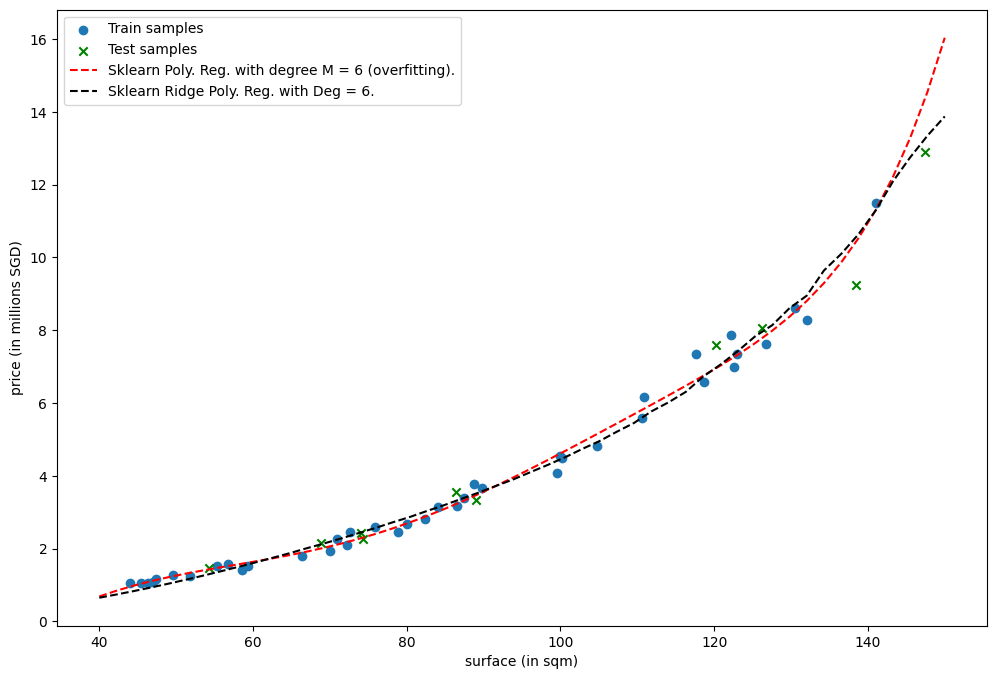

In [11]:
# Display dataset
plt.figure(figsize = (12, 8))
plt.scatter(train_inputs, train_outputs, label = 'Train samples')
plt.scatter(test_inputs, test_outputs, c = 'g', marker = "x", label = 'Test samples')
plt.xlabel("surface (in sqm)")
plt.ylabel("price (in millions SGD)")

# Optimal poly reg (with degree M = 6)
polyreg_dataset1_inputs, polyreg_dataset1_outputs = polyreg_matplotlib(poly_reg_model, n_degree, min_surf, max_surf, n_points)
legend1 = "Sklearn Poly. Reg. with degree M = 6 (overfitting)."
plt.plot(polyreg_dataset1_inputs, polyreg_dataset1_outputs, 'r--', label = legend1)

# Optimal ridge reg (M = 6), to see how its regularization helps avoid overfitting
polyreg_dataset2_inputs, polyreg_dataset2_outputs = ridgereg_matplotlib(ridge_reg, n_degree2, min_surf, max_surf, n_points)
legend2 = "Sklearn Ridge Poly. Reg. with Deg = 6."
plt.plot(polyreg_dataset2_inputs, polyreg_dataset2_outputs, 'k--', label = legend2)

# Display
plt.legend(loc = 'best')
plt.show()

### Predicting with a ridge regressor

In [12]:
# Helper function for prediction evaluation
# Return interval of min and max values, along with avg value for given surface
def theoretical_values(surface):
    avg_val = round((100000 + 14373*surface + 3*surface**3))/1000000
    min_val = 0.9*avg_val
    max_val = 1.1*avg_val
    return [min_val, avg_val, max_val]

In [13]:
# Predicting with model
new_surface = 150
out = ridge_reg.predict([[new_surface]])[0]
print(out, theoretical_values(new_surface))
out = poly_reg_model.predict(np.array([[(new_surface)**(i+1) for i in range(n_degree2)]]))[0]
print(out, theoretical_values(new_surface))

13.87601694467931 [11.142855, 12.38095, 13.619045000000002]
16.038864462389874 [11.142855, 12.38095, 13.619045000000002]


### On the impact of the $ \alpha $ regularization term

Note: Sklearn uses $ \alpha $ to designate the regularization parameter. This is somewhat sketchy and could lead to confusion with the learning rate of the Gradient Descent used for training. For the sake of clarity, we will stick to the notation used in the Sklearn functions, but it is important you do not confuse the two!

The parameter $ \alpha $ in front of the regularization term is used to weight the importance of the regularization term compared to the MSE. This is an hyperparemeter, which requires manual testing.

In order to visualize its impact on the ridge regression model, we will create three models, with different values of $ \alpha $:
- **Model 1:** If the value for $ \alpha $ is small, the loss function will be mostly MSE and our model will therefore suffer from the same overfitting problems as our previous model.
- **Model 2:** If the value of $ \alpha $ is too high however, the model will mostly ignore the MSE part of the loss function, which will lead to a model not fitting the data.
- **Model 3:** If the value of $ \alpha $ is "just right", then we will obtain a model that correctly fits the data and does not show signs of overfitting at the same time.

We start by training the three models below, with the $ \alpha $ values being 5e-25, 5e25 and 5e-2 respectively. We can then display the model curves to visualize the impact of the $ \alpha $ term.

In [14]:
# Training a Ridge Polynomial Regressor with Regularization, aka as a Ridge model
n_degree2 = 6
sk_inputs2 = np.array(train_inputs).reshape(-1, 1)
sk_outputs2 = np.array(train_outputs)
ridge_reg1 = KernelRidge(alpha = 0, kernel = 'polynomial', degree = n_degree2)
ridge_reg1.fit(sk_inputs2, sk_outputs2)
ridge_reg2 = KernelRidge(alpha = 5e25, kernel = 'polynomial', degree = n_degree2)
ridge_reg2.fit(sk_inputs2, sk_outputs2)
ridge_reg3 = KernelRidge(alpha = 5e-2, kernel = 'polynomial', degree = n_degree2)
ridge_reg3.fit(sk_inputs2, sk_outputs2)
print(ridge_reg1, ridge_reg2, ridge_reg3)

KernelRidge(alpha=0, degree=6, kernel='polynomial') KernelRidge(alpha=5e+25, degree=6, kernel='polynomial') KernelRidge(alpha=0.05, degree=6, kernel='polynomial')


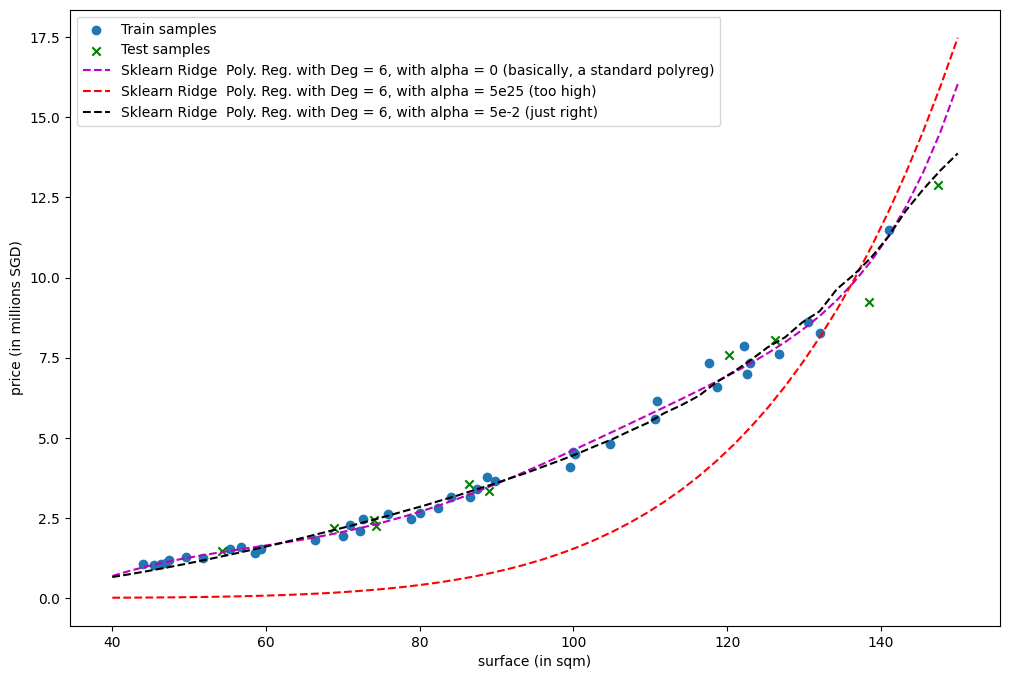

In [15]:
# Display dataset
plt.figure(figsize = (12, 8))
plt.scatter(train_inputs, train_outputs, label = 'Train samples')
plt.scatter(test_inputs, test_outputs, c = 'g', marker = "x", label = 'Test samples')
plt.xlabel("surface (in sqm)")
plt.ylabel("price (in millions SGD)")

# Optimal ridge reg (M = 6), to see how its regularization helps avoid overfitting
# Alpha term too low.
polyreg_dataset1_inputs, polyreg_dataset1_outputs = polyreg_matplotlib(poly_reg_model, n_degree, min_surf, max_surf, n_points)
legend2 = "Sklearn Ridge  Poly. Reg. with Deg = 6, with alpha = 0 (basically, a standard polyreg)"
plt.plot(polyreg_dataset1_inputs, polyreg_dataset1_outputs, 'm--', label = legend2)

# Optimal ridge reg (M = 6), to see how its regularization helps avoid overfitting
# Alpha term too low.
polyreg_dataset2_inputs, polyreg_dataset2_outputs = ridgereg_matplotlib(ridge_reg2, n_degree2, min_surf, max_surf, n_points)
legend3 = "Sklearn Ridge  Poly. Reg. with Deg = 6, with alpha = 5e25 (too high)"
plt.plot(polyreg_dataset2_inputs, polyreg_dataset2_outputs, 'r--', label = legend3)

# Alpha term just right.
polyreg_dataset3_inputs, polyreg_dataset3_outputs = ridgereg_matplotlib(ridge_reg3, n_degree2, min_surf, max_surf, n_points)
legend1 = "Sklearn Ridge  Poly. Reg. with Deg = 6, with alpha = 5e-2 (just right)"
plt.plot(polyreg_dataset3_inputs, polyreg_dataset3_outputs, 'k--', label = legend1)

# Display
plt.legend(loc = 'best')
plt.show()

### What's next?

In the next notebook, we will discuss how to move from linear regression to logistic regression for classification.